In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from Bio import Phylo


In [2]:
# read C:\Users\pablo\OneDrive\Desktop\tree_clustering\data\traits_pred_log.csv
data = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\traits_pred_log.csv')
trait_cols = data.columns[1:]
# read taxonomic_information.csv
tax = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\taxonomic_information.csv')
# C:\Users\pablo\OneDrive\Desktop\tree_clustering\output\imputed_data\gaussian_mixture\clusters_200.csv
clusters = pd.read_csv('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\output\\complete_data\\gaussian_mixture_full\\clusters_400.csv')

# read tree newick file
tree_path = ('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\phy_tree_BGCI_full.newick')
tree = Phylo.read(tree_path, 'newick')

# read C:\Users\pablo\OneDrive\Desktop\tree_clustering\data\phylogenetic_distance_matrix_BGCI_full.arrow
phylo_dist = pd.read_feather('C:\\Users\\pablo\\OneDrive\\Desktop\\tree_clustering\\data\\phylogenetic_distance_matrix_BGCI_full.arrow')

## Phylo distance

In [3]:
np.mean(phylo_dist.values)

253.56412984659855

In [4]:
# make index match column names for phylo_dist
phylo_dist.index = phylo_dist.columns

In [35]:
k_list = clusters['cluster'].unique()
n_species_list = []
mean_distance_list = []


for k in k_list:
    cluster_k = clusters[clusters['cluster'] == k]

    # get species from cluster_k (accepted_bin)
    species = cluster_k['accepted_bin']
    # change spaces to underscores
    species = species.str.replace(' ', '_')

    # iterate over species and get the phylogenetic distance
    phylo_dist_k = phylo_dist.loc[species, species]

    # get the mean phylogenetic distance (for non-diagonal elements)    
    mean_k = np.mean(phylo_dist_k[phylo_dist_k != 0])

    print(f'Cluster {k}, mean distance {mean_k}, n_species {len(species)}')

    n_species_list.append(len(species))
    mean_distance_list.append(mean_k)

Cluster 30, mean distance 63.12657507488133, n_species 1121
Cluster 300, mean distance 59.26814672796458, n_species 906
Cluster 368, mean distance 227.919766491054, n_species 825
Cluster 52, mean distance 234.43936145945278, n_species 802
Cluster 54, mean distance 123.80075900907198, n_species 767
Cluster 3, mean distance 230.6804976771865, n_species 538
Cluster 375, mean distance 27.301759917808212, n_species 511
Cluster 85, mean distance 15.491496418388447, n_species 506
Cluster 216, mean distance 217.57362612711827, n_species 480
Cluster 58, mean distance 237.4386787356824, n_species 461
Cluster 25, mean distance 221.1715180310977, n_species 430
Cluster 157, mean distance 30.11443673551402, n_species 428
Cluster 77, mean distance 53.236756021152516, n_species 422
Cluster 194, mean distance 236.42911994940334, n_species 414
Cluster 148, mean distance 40.49303671723352, n_species 375
Cluster 100, mean distance 18.547464011494263, n_species 348
Cluster 10, mean distance 63.321873989675

In [5]:
# see cluster 234
cluster_234 = clusters[clusters['cluster'] == 234]
cluster_234


,accepted_bin,Bark thickness,Crown diameter,Crown height,Leaf K per mass,Leaf N per mass,Leaf P per mass,Leaf Vcmax per dry mass,Leaf area,Leaf density,...,Root depth,Seed dry mass,Specific leaf area,Stem conduit diameter,Stem diameter,Stomatal conductance,Tree height,Wood density,cluster,cluster_size
54120,Cryptocarya acuminata,1.3,2.1,2.3,2.3,2.8,-0.2,-1.2,4.3,-1.1,...,1.6,5.7,2.2,3.1,-0.7,4.8,3.6,-0.7,234,18
54121,Cryptocarya ovalifolia,1.3,2.1,2.4,2.2,2.7,-0.2,-1.2,3.9,-1.0,...,1.6,5.9,2.1,3.1,-0.7,4.8,3.5,-0.6,234,18
54122,Ephippiandra madagascariensis,1.1,2.2,2.4,2.4,2.9,0.2,-1.2,4.4,-1.1,...,1.6,3.6,2.3,3.1,-0.9,4.7,3.2,-0.8,234,18
54123,Forestiera angustifolia,1.1,2.0,2.4,2.3,2.7,0.2,-1.0,3.9,-0.9,...,1.5,3.7,2.2,3.2,-0.6,4.9,2.9,-0.4,234,18
54124,Ocotea racemosa,0.7,2.1,2.4,1.8,2.9,-0.1,-1.4,4.3,-0.6,...,1.8,5.6,2.1,3.1,-0.6,4.8,3.4,-0.7,234,18
54125,Plagioscyphus louvelii,1.0,1.8,2.2,2.2,3.0,0.2,-1.1,3.7,-0.9,...,2.0,5.0,2.3,3.2,-0.9,5.0,3.4,-0.6,234,18
54126,Pyrus cordata,0.9,2.6,2.1,2.3,2.7,0.6,-0.6,2.6,-1.0,...,1.9,5.0,2.2,3.3,-0.2,5.0,3.0,-0.4,234,18
54127,Pyrus elaeagnifolia,0.9,2.6,2.1,2.3,2.7,0.6,-0.6,2.6,-1.0,...,1.9,5.0,2.2,3.3,-0.2,5.0,3.0,-0.4,234,18
54128,Pyrus regelii,0.9,2.6,2.1,2.3,2.7,0.6,-0.6,2.6,-1.0,...,1.9,5.0,2.2,3.3,-0.2,5.0,3.0,-0.4,234,18
54129,Pyrus salicifolia,0.9,2.6,2.1,2.3,2.7,0.6,-0.6,2.6,-1.0,...,1.9,5.0,2.2,3.3,-0.2,5.0,3.0,-0.4,234,18


Text(0, 0.5, 'Mean phylogenetic distance')

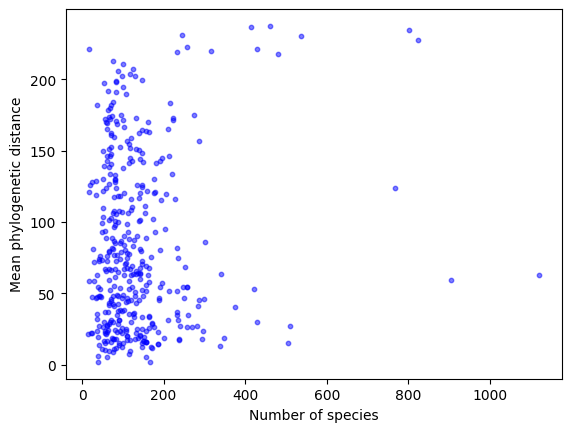

In [38]:
# plot mean distance vs n_species
plt.scatter(n_species_list, mean_distance_list,
            s = 10, c = 'blue', alpha = 0.5)
plt.xlabel('Number of species')
plt.ylabel('Mean phylogenetic distance')


## Taxonomy


In [39]:
# join data and tax on accepted_bin columns
df = pd.merge(data, tax, on='accepted_bin')

In [15]:
# count how many species are for each group
df_group = df.groupby('group').count().reset_index()
df_group
### doesn't match with the number of species in the original data (Maynard et al. 2022)

,group,accepted_bin,Bark thickness,Crown diameter,Crown height,Leaf K per mass,Leaf N per mass,Leaf P per mass,Leaf Vcmax per dry mass,Leaf area,...,Specific leaf area,Stem conduit diameter,Stem diameter,Stomatal conductance,Tree height,Wood density,genus,family,order,mono_fern
0,Angiosperms,53524,53524,53524,53524,53524,53524,53524,53524,53524,...,53524,53524,53524,53524,53524,53524,53524,53524,53524,53524
1,Gymnosperms,571,571,571,571,571,571,571,571,571,...,571,571,571,571,571,571,571,571,571,571


In [4]:
# count unique for each tax column
# tax = tax.drop(columns=['accepted_bin'])
tax_count = tax.nunique()
print(tax_count)

genus            4013
family            253
order              57
group               2
accepted_bin    54095
mono_fern           2
dtype: int64


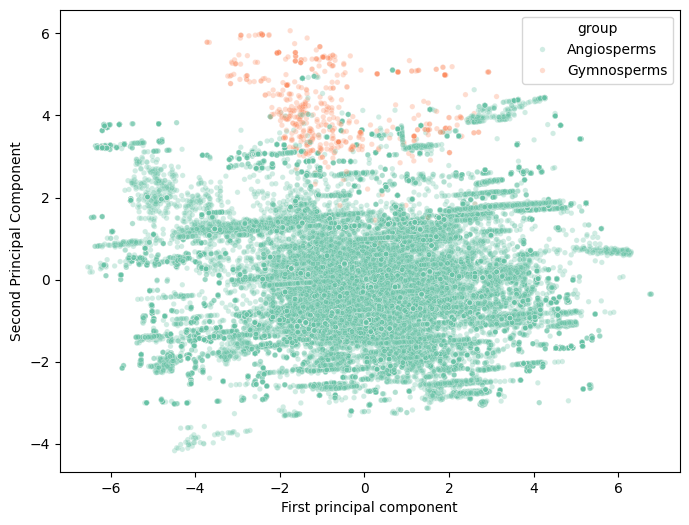

[0.51226002 0.19502879 0.08100309 0.04513813 0.03168642 0.02771892
 0.02274302 0.01600429]


In [8]:
# perform PCA over trait columns 
# scaler = StandardScaler()
# scaler.fit(df[trait_cols])
# scaled_data = scaler.transform(df[trait_cols])
pca = PCA(n_components=8)
pca.fit(df[trait_cols])
x_pca = pca.transform(df[trait_cols])
df['PC1'] = x_pca[:,0]
df['PC2'] = x_pca[:,1]

# plot PC1 vs PC2 using group as hue
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1',y='PC2',data=df,hue='group',
                s = 15, alpha = 0.3, palette = 'Set2')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.show()

# see how much variance is explained by each PC
print(pca.explained_variance_ratio_)


In [52]:
# join data of clusters and tax on accepted_bin columns
df_clusters = pd.merge(clusters, tax, on='accepted_bin')

In [53]:
tax_columns = ['genus', 'family', 'order', 'group']
# for each cluster, count the number of each taxonomic group using groupby
df_tax_count = df_clusters.groupby('cluster')[tax_columns].nunique()

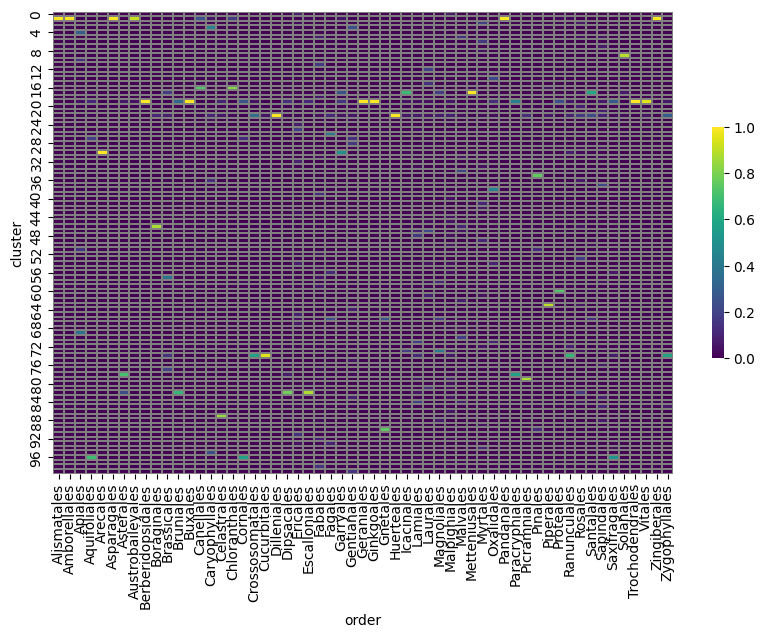

In [75]:
# pivot table for clusters and order
df_cluster_order = df_clusters.pivot_table(index='cluster', columns='order', values='accepted_bin', aggfunc='count', fill_value=0)

# Normalize by columns to get proportions
df_cluster_order = df_cluster_order.div(df_cluster_order.sum(axis=0), axis=1)

# plot heatmap of df_cluster_order
plt.figure(figsize=(10,6))
sns.heatmap(df_cluster_order, cmap='viridis', cbar=True, annot=False,
                 cbar_kws={'shrink': 0.5}, linewidths=0.004, linecolor='gray')
# show x ticks in the center of the cell
plt.xticks(np.arange(df_cluster_order.shape[1]) + 0.5, df_cluster_order.columns, rotation=90)
plt.show()


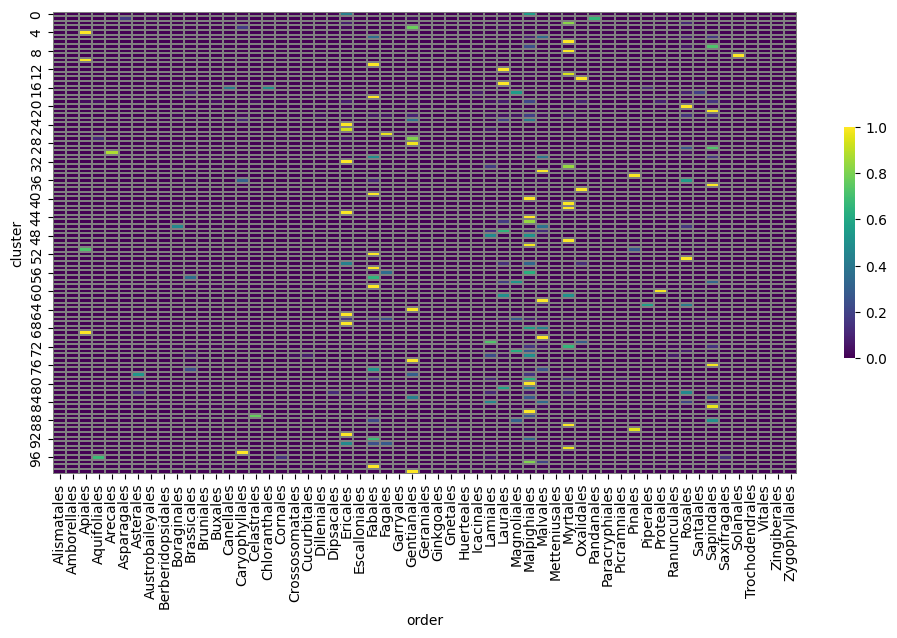

In [76]:
# pivot table for clusters and order
df_cluster_order = df_clusters.pivot_table(index='cluster', columns='order', values='accepted_bin', aggfunc='count', fill_value=0)

# Normalize by rows to get proportions
df_norm_rows = df_cluster_order.div(df_cluster_order.sum(axis=1), axis=0)

# plot heatmap of df_cluster_order
plt.figure(figsize=(12,6))
sns.heatmap(df_norm_rows, cmap='viridis', cbar=True, annot=False,
                 cbar_kws={'shrink': 0.5}, linewidths=0.004, linecolor='gray')
# show x ticks in the center of the cell
plt.xticks(np.arange(df_cluster_order.shape[1]) + 0.5, df_cluster_order.columns, rotation=90)
plt.show()

C:\Users\pablo\AppData\Local\Temp\ipykernel_9624\647162231.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_norm_rows.loc[ix, 'mean'] = row_mean


<Axes: xlabel='mean', ylabel='Count'>

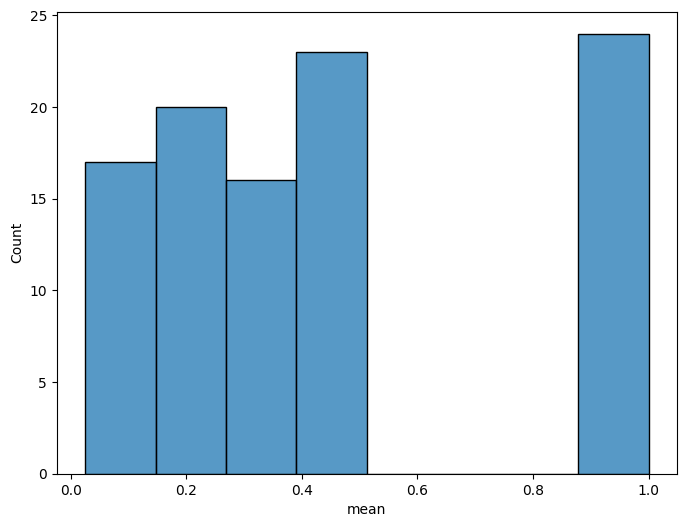

In [82]:
df_norm_rows['mean'] = 0
for ix, c in df_norm_rows.iterrows():
    row_mean = np.mean(c[c>0])
    df_norm_rows.loc[ix, 'mean'] = row_mean

# plot histogram of mean proportions
plt.figure(figsize=(8,6))
sns.histplot(df_norm_rows['mean'])

In [18]:
# # fit gaussian mixture
# from sklearn.mixture import GaussianMixture
# X = df[trait_cols]

# model = GaussianMixture(n_components=200, covariance_type='tied')
# model.fit(X)
# labels = model.predict(X)

# # add labels to df
# df['labels'] = labels

In [4]:
# Creating a pivot table with counts
pivot_table = df.pivot_table(index='cluster', columns='accepted_bin', aggfunc='size', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='d')  # `fmt='d'` displays integer formatting
plt.title('Heatmap of Accepted Bins within Labels')
plt.xlabel('Accepted Bin')
plt.ylabel('Labels')
plt.show()

KeyboardInterrupt: 

In [6]:
# for each label show how many of each distinct group there are
grouped = df.groupby('cluster').accepted_bin.value_counts()

# Plotting
grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Accepted Bins within Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.legend(title='Accepted Bin')
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area.
plt.show()